# Espace latent et factorisation matricielle

Le problème dit de recommendation consiste à partir d'un historique d'avis que des utilisateurs ont donné sur  un ensemble d'items de prédire les avis non observés (par exemple des notes sur des films, des achats de produits, ...). Les techniques de factorisation matricelle permettent dans ce cadre (et plus généralement) de mettre en évidence un espace "latent" (non directement observé dans les données) qui explicite les corrélations entre les avis des utilisateurs et les produits (par exemple genre des films ou profil d'utilisateurs).

Nous allons utiliser dans la suite les données movielens de notes d'utilisateurs sur des films.

## Stochastic gradient descent

Soit un ensemble de $m$ utilisateurs $U$ et un ensemble de $n$ items $I$, et une matrice $R$ de dimension $m\times n $ telle que $r_{u,i}$ représente la note que l'utilisateur $u$ a donné à l'item $i$, 0 si pas de note correspondante (on suppose les notes $>0$). Dans cette partie, l'hypothèse est qu'il existe un espace latent de dimension $d$ "commun" aux utilisateurs et aux items, qui permet d'expliquer par une combinaison linéaires les goùts des utilisateurs. Dans le cadre de la recommendation de films par exemple, cet espace pourrait décrire des genres de films. A chaque utilisateur $u$ correspond un vecteur de pondération $x$ de taille $d$ qui indique les intérêts de l'utilisateur en fonction de chaque genre; à chaque film $i$ correspond un vecteur de pondération $y$ de taille $d$ qui indique la corrélation du film avec chaque genre.

L'objectif est ainsi de trouver deux matrices $X$ et $Y$ de tailles $m\times d$ et $d\times n$ telles que $R \approx X Y$.
On utilise en général les moindres carrés comme fonction de coût pour calculer l'erreur de reconstruction.
Comme seule une partie des scores est observée lors de l'apprentissage, l'erreur ne doit être comptée que pour ces scores là.
La fonction à optimiser est $min_{X,Y} \sum_{u,i|r_{u,i}>0} (r_{u,i}-y_{.,i}'x_{u,.})^2+\lambda (||y_{.,i}||^2+||x_{u,.}||^2)$.

Une manière d'optimiser la fonction est par descente de gradient stochastique, avec les formules de mise-à-jour suivantes :

* $e_{u,i} =  r_{ui}-y_{.,i}'x_{u,.}$

* $y_{.,i} = y_{.,i}+\gamma (e_{u,i}x_{u,.} -\lambda y_{.,i})$

* $x_{u,.} = x_{u,.}+\gamma (e_{u,i}y_{.,i} -\lambda x_{u,.})$


Le code suivant permet de charger les données movielens (données à charger à partir de http://grouplens.org/datasets/movielens/1m/, le MovieLens 1M Dataset par exemple).

In [1]:
import numpy as np
def read_movielens():
    users = dict()
    movies = dict()
    with open('users.dat', "r",encoding = 'iso-8859-1') as f:
        for l in f:
            l = l.strip().split("::")
            users[int(l[0])] = [l[1], int(l[2]), int(l[3]), l[4]]
    with open('movies.dat', "r",encoding = 'iso-8859-1') as f:
        for l in f:
            l = l.strip().split("::")
            movies[int(l[0])] = [l[1],l[2].split("|")]
    ratings = np.zeros((max(users)+1,max(movies)+1))
    with open('ratings.dat',"r",encoding = 'iso-8859-1') as f:
        for l in f:
            l = l.strip().split("::")
            ratings[int(l[0]),int(l[1])]=int(l[2])
    return ratings, users, movies


### nb_movies, nb_users : nombre de movies, users
### ratings : matrice users x movies avec les notes
### users : dictionnaire des users avec les infos 
### movies : dictionnaire des films avec les infos
### genres, genres_id : mapping des genres vers identifiants
### movies_genres : matrice binaire  movies x genres avec un 1 si film du genre 

ratings,users,movies = read_movielens()
nb_movies = max(movies)
nb_users = max(users)
genres =  {0: 'Action', 1: 'Adventure', 2: 'Animation', 3: "Children's", 4: 'Comedy', 
           5: 'Crime', 6: 'Documentary', 7: 'Drama', 8: 'Fantasy', 9: 'Film-Noir',
           10: 'Horror', 11: 'Musical', 12: 'Mystery', 13: 'Romance', 14: 'Sci-Fi',
           15: 'Thriller', 16: 'War', 17: 'Western'}
genres_id = dict(zip(genres.values(),genres.keys()))
movies_genres = np.zeros((nb_movies, len(genres)))
for idx,m in movies.items():
    for g in m[1]:
        movies_genres[idx-1][genres_id[g]]=1.0



In [2]:
print(movies_genres.shape)
print(ratings.shape)
print(len(users))
print(len(movies))

(3952, 18)
(6041, 3953)
6040
3883


In [4]:
class GradientDescent:
    def __init__(self,ratings,gamma=0.01,lambd=0.005, max_iter=30):
        self.max_iter=max_iter
        self.gamma=gamma
        self.lambd=lambd
        self.nz = ratings.nonzero()
    def fit(self, ratings):
        self.i=0
        self.x,self.y = np.random.random((nb_users+1, len(genres))), np.random.random((len(genres),nb_movies+1))
        index = ratings.nonzero()
        L = []
        for i in range(len(index[0])):
            L.append((index[0][i],index[1][i]))
        while (self.i<=self.max_iter):
            np.random.shuffle(L)
            idx = np.array(L)
            for idx_u, idx_i in zip(idx[:,0],idx[:,1]):
                e = ratings[idx_u][idx_i] - np.dot(self.x[idx_u,:],self.y[:,idx_i])
                self.y[:,idx_i] = self.y[:,idx_i] + self.gamma*(e*self.x[idx_u,:] - self.lambd*self.y[:,idx_i])
                self.x[idx_u,:] = self.x[idx_u,:] + self.gamma*(e*self.y[:,idx_i] - self.lambd*self.x[idx_u,:])
            print(self.i," iterations ")
            self.error(ratings)
            self.i+=1
    def error(self, ratings):
        temp = ((ratings-np.dot(self.x,self.y))[self.nz]**2).mean()
        print("erreur = ", temp)

In [5]:
G = GradientDescent(ratings)
G.fit(ratings)

0  iterations 
erreur =  0.857383854237
1  iterations 
erreur =  0.823954812475
2  iterations 
erreur =  0.800493854544
3  iterations 
erreur =  0.772335903002
4  iterations 
erreur =  0.742075421266
5  iterations 
erreur =  0.718166334523
6  iterations 
erreur =  0.696876841266
7  iterations 
erreur =  0.677966691616
8  iterations 
erreur =  0.663646542991
9  iterations 
erreur =  0.648133822743
10  iterations 
erreur =  0.636663270614
11  iterations 
erreur =  0.628185359888
12  iterations 
erreur =  0.61796711964
13  iterations 
erreur =  0.610221709088
14  iterations 
erreur =  0.604006751081
15  iterations 
erreur =  0.59820690798
16  iterations 
erreur =  0.592288908052
17  iterations 
erreur =  0.588347601748
18  iterations 
erreur =  0.582527500838
19  iterations 
erreur =  0.578068828322
20  iterations 
erreur =  0.574597990215
21  iterations 
erreur =  0.571107180928
22  iterations 
erreur =  0.568603658714
23  iterations 
erreur =  0.564872247735
24  iterations 
erreur =  0.

Tester le sur les données movielens et analyser les résultats.

Nous obtenons une convergence de la méthode et une erreur moyenne de 0.55 . L'introduction d'un terme de régularisation a permis de baisser l'erreur. La convergence reste cependant la même.


<h2>Visualisation : algorithmes MDS et t-SNE</h2>
Afin de pouvoir visualiser les données, nous avons  besoin d'une réduction de dimension très forte (en 2 ou 3d ...). L'objectif de la plupart des algorithmes dans ce domaine est de préserver les distances locales lors des projections. Deux exemples d'algorithmes sont  "MultiDimensional scaling" (MDS) et t-Stochastic Neighbor Embedding (t-SNE). MDS utilise une approche algébrique par identification de valeurs propres à partir d'une matrice de similarité entre données; t-SNE utilise  une modélisation probabiliste en étudiant la KL-divergence entre la distribution des points dans l'espace originale et dans l'espace projeté.

Scikit-learn implémente ces deux algos. Etudier les résultats précédents en visualisant les données à partir de la nouvelle représentation et par MDS ou t-SNE. Vous pouvez utiliser pour cela une similarité cosinus : $\frac{u . v}{||u||||v||}$ mieux adapté aux grandes dimensions (pourquoi ?) pour MDS, et les coordonnées des films dans l'espace latent trouvé dans les questions précédentes pour t-SNE. Utiliser l'information sur les genres pour analyser vos résultats.

documentation : 
http://scikit-learn.org/stable/modules/manifold.html#multi-dimensional-scaling-mds


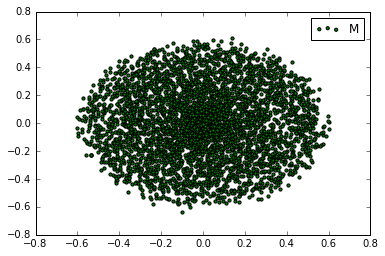

In [6]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

from sklearn import manifold
from sklearn import metrics
%matplotlib inline
seed = np.random.RandomState(seed=3)


ratings_est = np.dot(G.x, G.y)
movies_similarities = metrics.pairwise.cosine_similarity(np.transpose(G.y))
users_similarities = metrics.pairwise.cosine_similarity(G.x)
ratings_similarities = metrics.pairwise.cosine_similarity(np.transpose(ratings_est))

mds = manifold.MDS(n_components=2, max_iter=10, eps=1e-6, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
movies_stressed = mds.fit(movies_similarities).embedding_
users_stressed = mds.fit(users_similarities).embedding_
ratings_stressed = mds.fit(ratings_similarities).embedding_

fig = plt.figure(2)
plt.scatter(movies_stressed[:, 0], movies_stressed[:, 1], s=10, c='g')
plt.legend(('Movie features stressed to 2D'), loc='best')


In [ ]:
tsne = manifold.TSNE(n_components=2, n_iter=300, learning_rate=1e-3, random_state=seed)
movies_stressed = tsne.fit(movies_similarities).embedding_
users_stressed = tsne.fit(users_similarities).embedding_
ratings_stressed = tsne.fit(ratings_similarities).embedding_

fig = plt.figure(2)
plt.scatter(movies_stressed[:, 0], movies_stressed[:, 1], s=10, c='g')
plt.legend(('Movie features stressed to 2D'), loc='best')